### Neutron Reflectometry analysis of an asymmetric lipid bilayer

#### Overview
This notebook performs neutron reflectometry analysis on a lipid bilayer system containing deuterated phospholipids in the inner leaflet and natural rough LPS in the outer leaflet. 

The analysis uses contrast variation with three different solvent conditions 
 


#### Experimental Conditions
- **D2O contrast**: Heavy water (SLD ≈ 6.35 × 10⁻⁶ Å⁻²) ---> 37969_70.dat 
- **SMW contrast**: Silicon-matched water (SLD ≈ 2.07 × 10⁻⁶ Å⁻²)  ---> 37971_72.dat 
- **H2O contrast**: Water (SLD ≈ -0.56 × 10⁻⁶ Å⁻²) ---> 37973_74.dat

-  Room temperature

#### Model Structure
The bilayer consists of 4 layers:
1. **Inner head groups** (phospholipid heads)
2. **Inner tails** (phospholipid tails)
3. **Outer tails** (LPS tails)
4. **LPS core** (outer head region)

in addition a silicon oxide layer is defined separately and incuded in the structure

In [1]:
# use matplotlib for plotting
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import os.path
    
import refnx, scipy
# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, Parameters, process_chain, Transform, load_chain, possibly_create_parameter

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet, Component, sld_profile

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

import periodictable
from multiprocessing import Pool

# Set random seeds for reproducibility
# This ensures that all stochastic processes (MCMC, differential evolution, etc.) 
# produce the same results on each run
SEED = 38  # You can change this value to get different but reproducible results

# Set seeds for different random number generators
np.random.seed(SEED)  # NumPy random seed

# For MCMC sampling specifically, you can also set the seed in the fitter
# This will be done later when creating the CurveFitter object

print(f"Random seeds set to {SEED} for reproducibility")

# version numbers used in this analysis
refnx.version.version, scipy.version.version, np.version.version


Random seeds set to 38 for reproducibility


('0.1.40', '1.11.3', '1.26.1')

#### Loading the data

In [2]:
# Load datasets

data_d2o = ReflectDataset('37969_70.dat')
data_d2o.name = "D2O_dataset"

data_smw = ReflectDataset('37971_72.dat')
data_smw.name = "SMW_dataset"

data_h2o = ReflectDataset('37973_74.dat')
data_h2o.name = "H2O_dataset"


#### Custom Bilayer component
Below we define a bilayer component model, used to calculate the scattering length density (SLD) and reflectivity profiles of the bilayer structure. The `Bilayer` class extends the `Component` class and integrates into the reflectometry fitting framework of `refnx` 

In [3]:
# The SiO2 slabs is defined outside this Component.
# the Bilayer Component describes the four layers of the asymmetric bilayer
class Bilayer(Component):
    def __init__(self, *pars):
        super().__init__(name='Bilayer')
        
        self.pnames = ['inner_head_thick', 'inner_head_sld', 'inner_head_hydration', 
                       'inner_tails_thick', 'inner_tails_sld', 
                       'outer_tails_thick', 'outer_tails_sld', 
                       'tails_hydration',
                       'outer_head_sld_ratio', 'outer_head_sld_d2o', 'outer_rough', 'core_thickness', 'core_hydration']
        
        self._pars = [possibly_create_parameter(p, name=pname) for pname, p in zip(self.pnames, pars)]        

        assert len(self._pars) == len(self.pnames) == 13
        
        for pname, p in zip(pnames, self._pars):
            setattr(self, pname, p)
    
        
        self._parameters = Parameters(data = self._pars, name=self.name)

    @property
    def parameters(self):
        return self._parameters

    def slabs(self, structure=None):
        """
        Slab representation of this component. See :class:`Component.slabs`
        """
        solvent = complex(structure.solvent)
        
        # calculate mole fraction of D2O from the bulk SLD
        rho_d2o = 6.35
        rho_h2o = -0.56
        d2o_molfr = (solvent - rho_h2o)/(rho_d2o - rho_h2o);
        
                
        # Use D2O mol fraction to calculate SLD that exchange in D2O, the 
        #_ratio parameters define the ratios between the SLDs in D2O and the SLDs in H2O
        # This ensures using sensible values for intermediate constrasts such as SMW 
        outer_head_sld = (self.outer_head_sld_d2o.value * d2o_molfr)
        outer_head_sld += (1 - d2o_molfr)*(self.outer_head_sld_ratio.value * self.outer_head_sld_d2o.value)
        
        # Account for bilayer hydration
        rhoInnerHead = self.inner_head_hydration.value * solvent
        rhoInnerHead += (1 - self.inner_head_hydration.value) * self.inner_head_sld.value

        rhoInnerTails = self.tails_hydration.value * solvent 
        rhoInnerTails += (1 - self.tails_hydration.value) * self.inner_tails_sld.value

        rhoOuterTails = self.tails_hydration.value * solvent 
        rhoOuterTails += (1- self.tails_hydration.value) * self.outer_tails_sld.value
        
        rhoOuterHead = self.core_hydration.value * solvent
        rhoOuterHead += (1 - self.core_hydration.value) * outer_head_sld
        
        
        orough = self.outer_rough.value     

        
        bilayer = np.array([
            [self.inner_head_thick.value, np.real(rhoInnerHead), np.imag(0), orough, 0],
            [self.inner_tails_thick.value, np.real(rhoInnerTails), np.imag(0), orough, 0],
            [self.outer_tails_thick.value, np.real(rhoOuterTails), np.imag(0), orough, 0],
            [self.core_thickness.value, np.real(rhoOuterHead), np.imag(0), orough, 0],
        ], dtype=float)
    
        return np.r_[bilayer]


#### Fitting conditions

In [4]:
# definition of parameters values, bounds and fitting conditions

pnames = ['inner_head_thick', 'inner_head_sld', 'inner_head_hydration',
          'inner_tails_thick', 'inner_tails_sld',
          'outer_tails_thick', 'outer_tails_sld',
          'tails_hydration', 
          'outer_head_sld_ratio', 'outer_head_sld_d2o', 'outer_rough', 'core_thickness', 'core_hydration']

# Create Parameter objects with value, vary flag, and bounds
base_pars = [('inner_head_thick',     10,    True,  (6, 11)),
             ('inner_head_sld',       1.9,   False, (1.6, 2.5)),
             ('inner_head_hydration', 0.32,  True,  (0.3, 0.6)),
             ('inner_tails_thick',    17.9,  True,  (14, 20)),
             ('inner_tails_sld',      6.06,  True,  (5.5, 7)),
             ('outer_tails_thick',    14,    True,  (12, 18)),
             ('outer_tails_sld',      -0.3,  True,  (-0.4, 1)),
             ('tails_hydration',      0.02,  True,  (0, 0.2)),
             ('outer_head_sld_ratio', 0.5,   False, (0.4, 0.6)),
             ('outer_head_sld_d2o',   4.8,   True,  (4, 4.8)),
             ('outer_rough',          4,     True,  (3, 6)),
             ('core_thickness',       28,    True,  (20, 40)),
             ('core_hydration',       0.48,  True,  (0.3, 0.6))]

pars = {p[0]: Parameter(value=p[1], vary=p[2], bounds=p[3], name=p[0]) for p in base_pars}

b = Bilayer(*(pars.values()))


#### Substrate and subphase parameters

In [5]:
si = SLD(2.07, 'Si')
sio2 = SLD(3.47, 'SiO2')


d2o = SLD(6.36, 'D2O')
h2o = SLD(-0.56, 'H2O')
smw = SLD(2.07, 'SMW')

d2o.real.setp(6.25, bounds=(6, 6.36), vary=True)
d2o.real.name='D2O SLD'

smw.real.setp(2.07, bounds=(1.8, 2.2), vary=True)
smw.real.name='SMW SLD'

h2o.real.setp(-0.56, bounds=(-0.56, -0.1), vary=True)
h2o.real.name='H2O SLD'

sio2_layer = sio2(15, 3)

sio2_layer.thick.name = 'SiO2 Thickness'
sio2_layer.thick.setp(13, bounds=(2, 30), vary=True)
sio2_layer.rough.name = 'SiO2 Roughness'
sio2_layer.rough.setp(4, bounds=(0, 12), vary=True)
sio2_layer.vfsolv.name = 'SiO2 Solvation'
sio2_layer.vfsolv.setp(0.1, bounds=(0., 0.5), vary=True)


#### Define the `structure` of the sample in three contrasts

In [6]:
s_d2o = si | sio2_layer | b | d2o(0, 3)
s_smw = si | sio2_layer | b | smw(0, 3)
s_h2o = si | sio2_layer | b | h2o(0, 3)

#### Define experimental parameters and assign them to the structures by creating a `model` for each curve

In [7]:
scale = Parameter(1, 'Common scale factor')
scale.setp(0.8158, bounds=(0.8, 1.2), vary=True)

bkg1 = Parameter(1e-6, 'Bkg1')
bkg1.setp(1e-6, bounds=(1e-8, 6e-6), vary=True)

bkg2 = Parameter(1e-6, 'Bkg2')
bkg2.setp(1e-6, bounds=(1e-8, 6e-6), vary=True)

bkg3 = Parameter(1e-6, 'Bkg3')
bkg3.setp(1e-6, bounds=(1e-8, 6e-6), vary=True)




model_d2o = ReflectModel(s_d2o, scale=scale, bkg=bkg1, dq=4, dq_type='constant')
model_smw = ReflectModel(s_smw, scale=scale, bkg=bkg2, dq=4, dq_type='constant')
model_h2o = ReflectModel(s_h2o, scale=scale, bkg=bkg3, dq=4, dq_type='constant')


#### Combine model and data into an `objective`

In [8]:
objective_d2o = Objective(model_d2o, data_d2o)
objective_smw = Objective(model_smw, data_smw)
objective_h2o = Objective(model_h2o, data_h2o)

#### Combine multiple objectives into a `global objective` to perform a constrained fit

In [9]:
objective_h2o.weighted = objective_smw.weighted = objective_d2o.weighted = True 

global_objective = GlobalObjective([objective_d2o, objective_smw, objective_h2o])

#### Print out the slab structure of the bilayer

In [10]:
s = Structure(solvent=d2o) 
b.slabs(s)

array([[10.        ,  3.292     ,  0.        ,  4.        ,  0.        ],
       [17.9       ,  6.0638    ,  0.        ,  4.        ,  0.        ],
       [14.        , -0.169     ,  0.        ,  4.        ,  0.        ],
       [28.        ,  5.47793922,  0.        ,  4.        ,  0.        ]])

#### Create a fitter object and perform fitting routine

In [11]:
# Note: Random seed for MCMC sampling is controlled by the global np.random.seed(SEED) 
# that we set earlier. The CurveFitter uses NumPy's random generator internally.

fitter = CurveFitter(global_objective) 

fitter.fit('differential_evolution', popsize=10);



-4105.9449367257375: : 43it [00:13,  3.14it/s]


#### Plot the obtained fits and corresponding datasets with vertical offsets and using RxQ^4 scaling

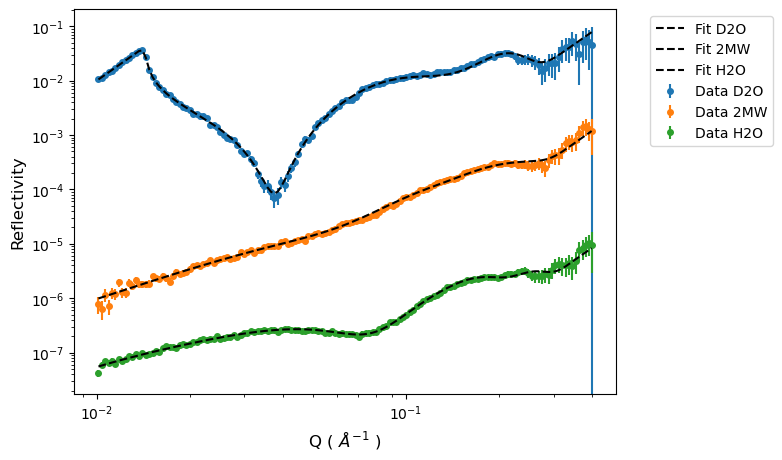

In [12]:
# Define the offsets for each dataset
offsets = [6, 4, 2] # set to [0,0,0] for no offset

marksize = 4
color = 'black'

# Define the scaling function for R*Q^4
def scale_y(y, x):
    return y  * x**4 # just return y for no R*Q^4

# Function to apply vertical offset
def apply_vertical_offset(y, offset):
    return y * 10**offset

fig1 = plt.figure(figsize=(7, 5))

# Define a list of objectives and labels
objectives = [objective_d2o, objective_smw, objective_h2o]
labels = ['D2O', '2MW', 'H2O']

# Loop over each objective and plot
for i, objective in enumerate(objectives):
    x, y, y_err = objective.data.x, objective.data.y, objective.data.y_err
    scaled_y = scale_y(apply_vertical_offset(y, offsets[i]), x)
    scaled_y_err = scale_y(apply_vertical_offset(y_err, offsets[i]), x)
    scaled_model_y = scale_y(apply_vertical_offset(objective.model(x), offsets[i]), x)

    plt.errorbar(x, scaled_y, scaled_y_err, label=f'Data {labels[i]}', fmt='o', markersize=marksize)
    plt.plot(x, scaled_model_y, label=f'Fit {labels[i]}', linestyle='--', color=color, zorder=10)

plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Q ( $Å^{-1}$ )', fontsize=12)
plt.ylabel('Reflectivity', fontsize=12)

plt.show()


#### Plot SLD profiles

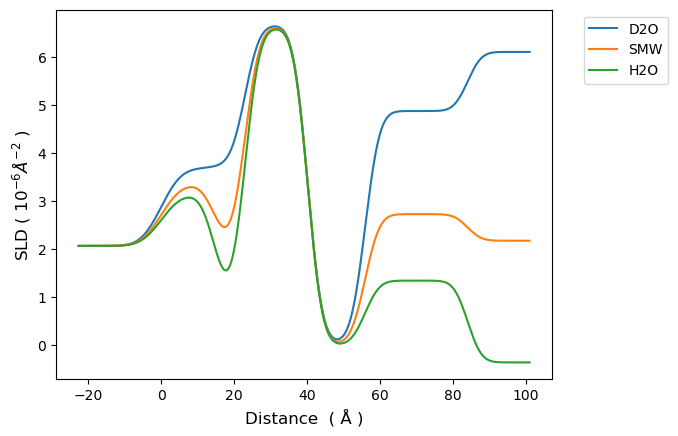

In [13]:
fig2, ax = plt.subplots()
ax.plot(*s_d2o.sld_profile(), label='D2O')
ax.plot(*s_smw.sld_profile(), label='SMW')
ax.plot(*s_h2o.sld_profile(), label='H2O')

ax.set_ylabel("SLD ( $10^{-6} \AA^{-2}$ )", fontsize = 12)
ax.set_xlabel("Distance  ( Å )", fontsize = 12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


#### Generate volume fraction plots

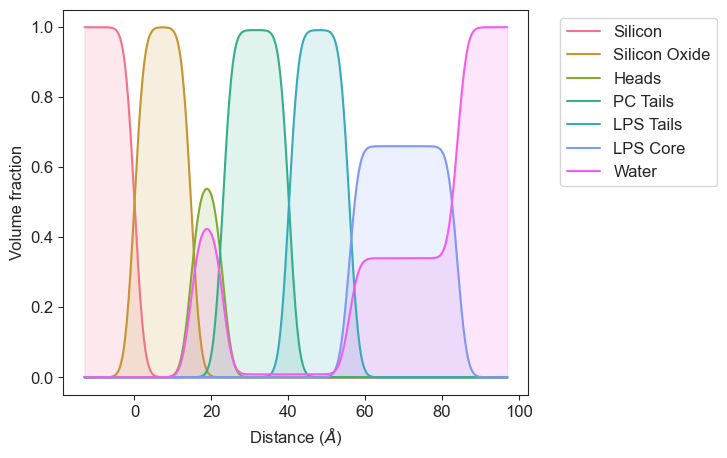

In [14]:
import seaborn as sns

# Set style
sns.set_style('ticks')

# Add your custom labels to this list
custom_labels = ["Silicon", "Silicon Oxide", "Heads", "PC Tails", "LPS Tails", 'LPS Core', "Water"]  # Example labels

def create_vfp(structure, solvent_slab=-1, roughness=2, labels=None):
    _slabs = structure.slabs().copy()

    if roughness is not None:
        _slabs[:, 3] = roughness
        
    # Create an array of hydration values for each slab in the structure
    hydration_values = np.zeros(len(_slabs))

    # Assign hydration values only to the layers of the Paracini component
    hydration_values[1:6] = np.array([ 0,
                                       b.inner_head_hydration.value,
                                       b.tails_hydration.value,
                                       b.tails_hydration.value,
                                       b.core_hydration.value])
                                                                       
    vf = 1 - hydration_values
    
    if solvent_slab is None:
        nvfp = len(_slabs) + 1
    else:
        nvfp = len(_slabs)
    
    z, sldp = sld_profile(_slabs) 
    vfp = np.zeros((nvfp, len(z)), float)
    
    for i in range(len(_slabs)):
        _slabs[:, 1:3] = 0
        _slabs[i, 1] = vf[i]
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[i] = _vfp
    
    # fix up the solvent vfp
    _slabs[:, 1] = hydration_values

    if solvent_slab is None:
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[-1] = _vfp
    else:
        _slabs[solvent_slab, 1] = 1
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[solvent_slab] = _vfp

    return z, vfp

z, vfp = create_vfp(s_d2o, solvent_slab=-1, labels=custom_labels)

# Get the "Paired" color palette from Seaborn
colors = sns.color_palette('husl', len(vfp))

fig3 = plt.figure(figsize=(6, 5))

for i in range(len(vfp)):
    sns.lineplot(x=z, y=vfp[i], label=custom_labels[i], color=colors[i])
    plt.fill_between(z, 0, vfp[i], color=colors[i], alpha=0.15)  # Shading under the line plot
    plt.ylabel('Volume fraction', fontsize=12)
    plt.xlabel('Distance ($\\AA$)', fontsize=12)
    plt.xticks(fontsize=12)  # Change the font size for x-axis tick labels
    plt.yticks(fontsize=12)  # Change the font size for y-axis tick labels

# Adding a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.show()


#### Perform MCMC analysis

In [15]:
fitter.reset()
fitter.sample(100, pool=1)
fitter.reset()


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


In [16]:
# MCMC sampling with reproducibility
# The random seed is already set via fitter.set_random_state(SEED) above
res = fitter.sample(100, nthin=10, pool=1)


100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


In [17]:
print(global_objective)


________________________________________________________________________________


--Global Objective--
________________________________________________________________________________
Objective - 5352864880
Dataset = D2O_dataset
datapoints = 147
chi2 = 81.36409030395266
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'Common scale factor', value=0.997114 +/- 0.00549, bounds=[0.8, 1.2]>
<Parameter:    'Bkg1'     , value=3.09715e-06 +/- 3.18e-07, bounds=[1e-08, 6e-06]>
<Parameter:'dq - resolution', value=4  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
____________________________________________________________

#### Print a summary of the fitted varying parameters and fitting metrics

In [18]:
#Display only the values that have been fitted plus other useful metrics
fitted_parameters = global_objective.parameters.varying_parameters() # List varying parameters
print(fitted_parameters)
print("number of fitted parameters: ", len(fitted_parameters)) 

number_of_exp_points = len(data_d2o) + len(data_smw) + len(data_h2o) 
print(" Number of experimental points: ", number_of_exp_points)
number_of_fitted_par = len(fitted_parameters)
print(" Number of fitted parameters: ", number_of_fitted_par)

chisquared = objective_d2o.chisqr() + objective_smw.chisqr() + objective_h2o.chisqr()
print(" chi^2 = ", chisquared)


print(" Reduced chi^2 = ", chisquared / (number_of_exp_points - number_of_fitted_par ))


________________________________________________________________________________
Parameters:      None      
<Parameter:'Common scale factor', value=0.997114 +/- 0.00549, bounds=[0.8, 1.2]>
<Parameter:    'Bkg1'     , value=3.09715e-06 +/- 3.18e-07, bounds=[1e-08, 6e-06]>
<Parameter:'SiO2 Thickness', value=15.5699 +/- 1.49 , bounds=[2.0, 30.0]>
<Parameter:'SiO2 Roughness', value=5.07372 +/- 1.44 , bounds=[0.0, 12.0]>
<Parameter:'SiO2 Solvation', value=0.0822792 +/- 0.025, bounds=[0.0, 0.5]>
<Parameter:'inner_head_thick', value=8.87851 +/- 1.35 , bounds=[6.0, 11.0]>
<Parameter:'inner_head_hydration', value=0.453309 +/- 0.0463, bounds=[0.3, 0.6]>
<Parameter:'inner_tails_thick', value=17.1011 +/- 0.54 , bounds=[14.0, 20.0]>
<Parameter:'inner_tails_sld', value=6.7137 +/- 0.153, bounds=[5.5, 7.0]>
<Parameter:'outer_tails_thick', value=16.6715 +/- 0.795, bounds=[12.0, 18.0]>
<Parameter:'outer_tails_sld', value=0.0359523 +/- 0.185, bounds=[-0.4, 1.0]>
<Parameter:'tails_hydration', value=0.017

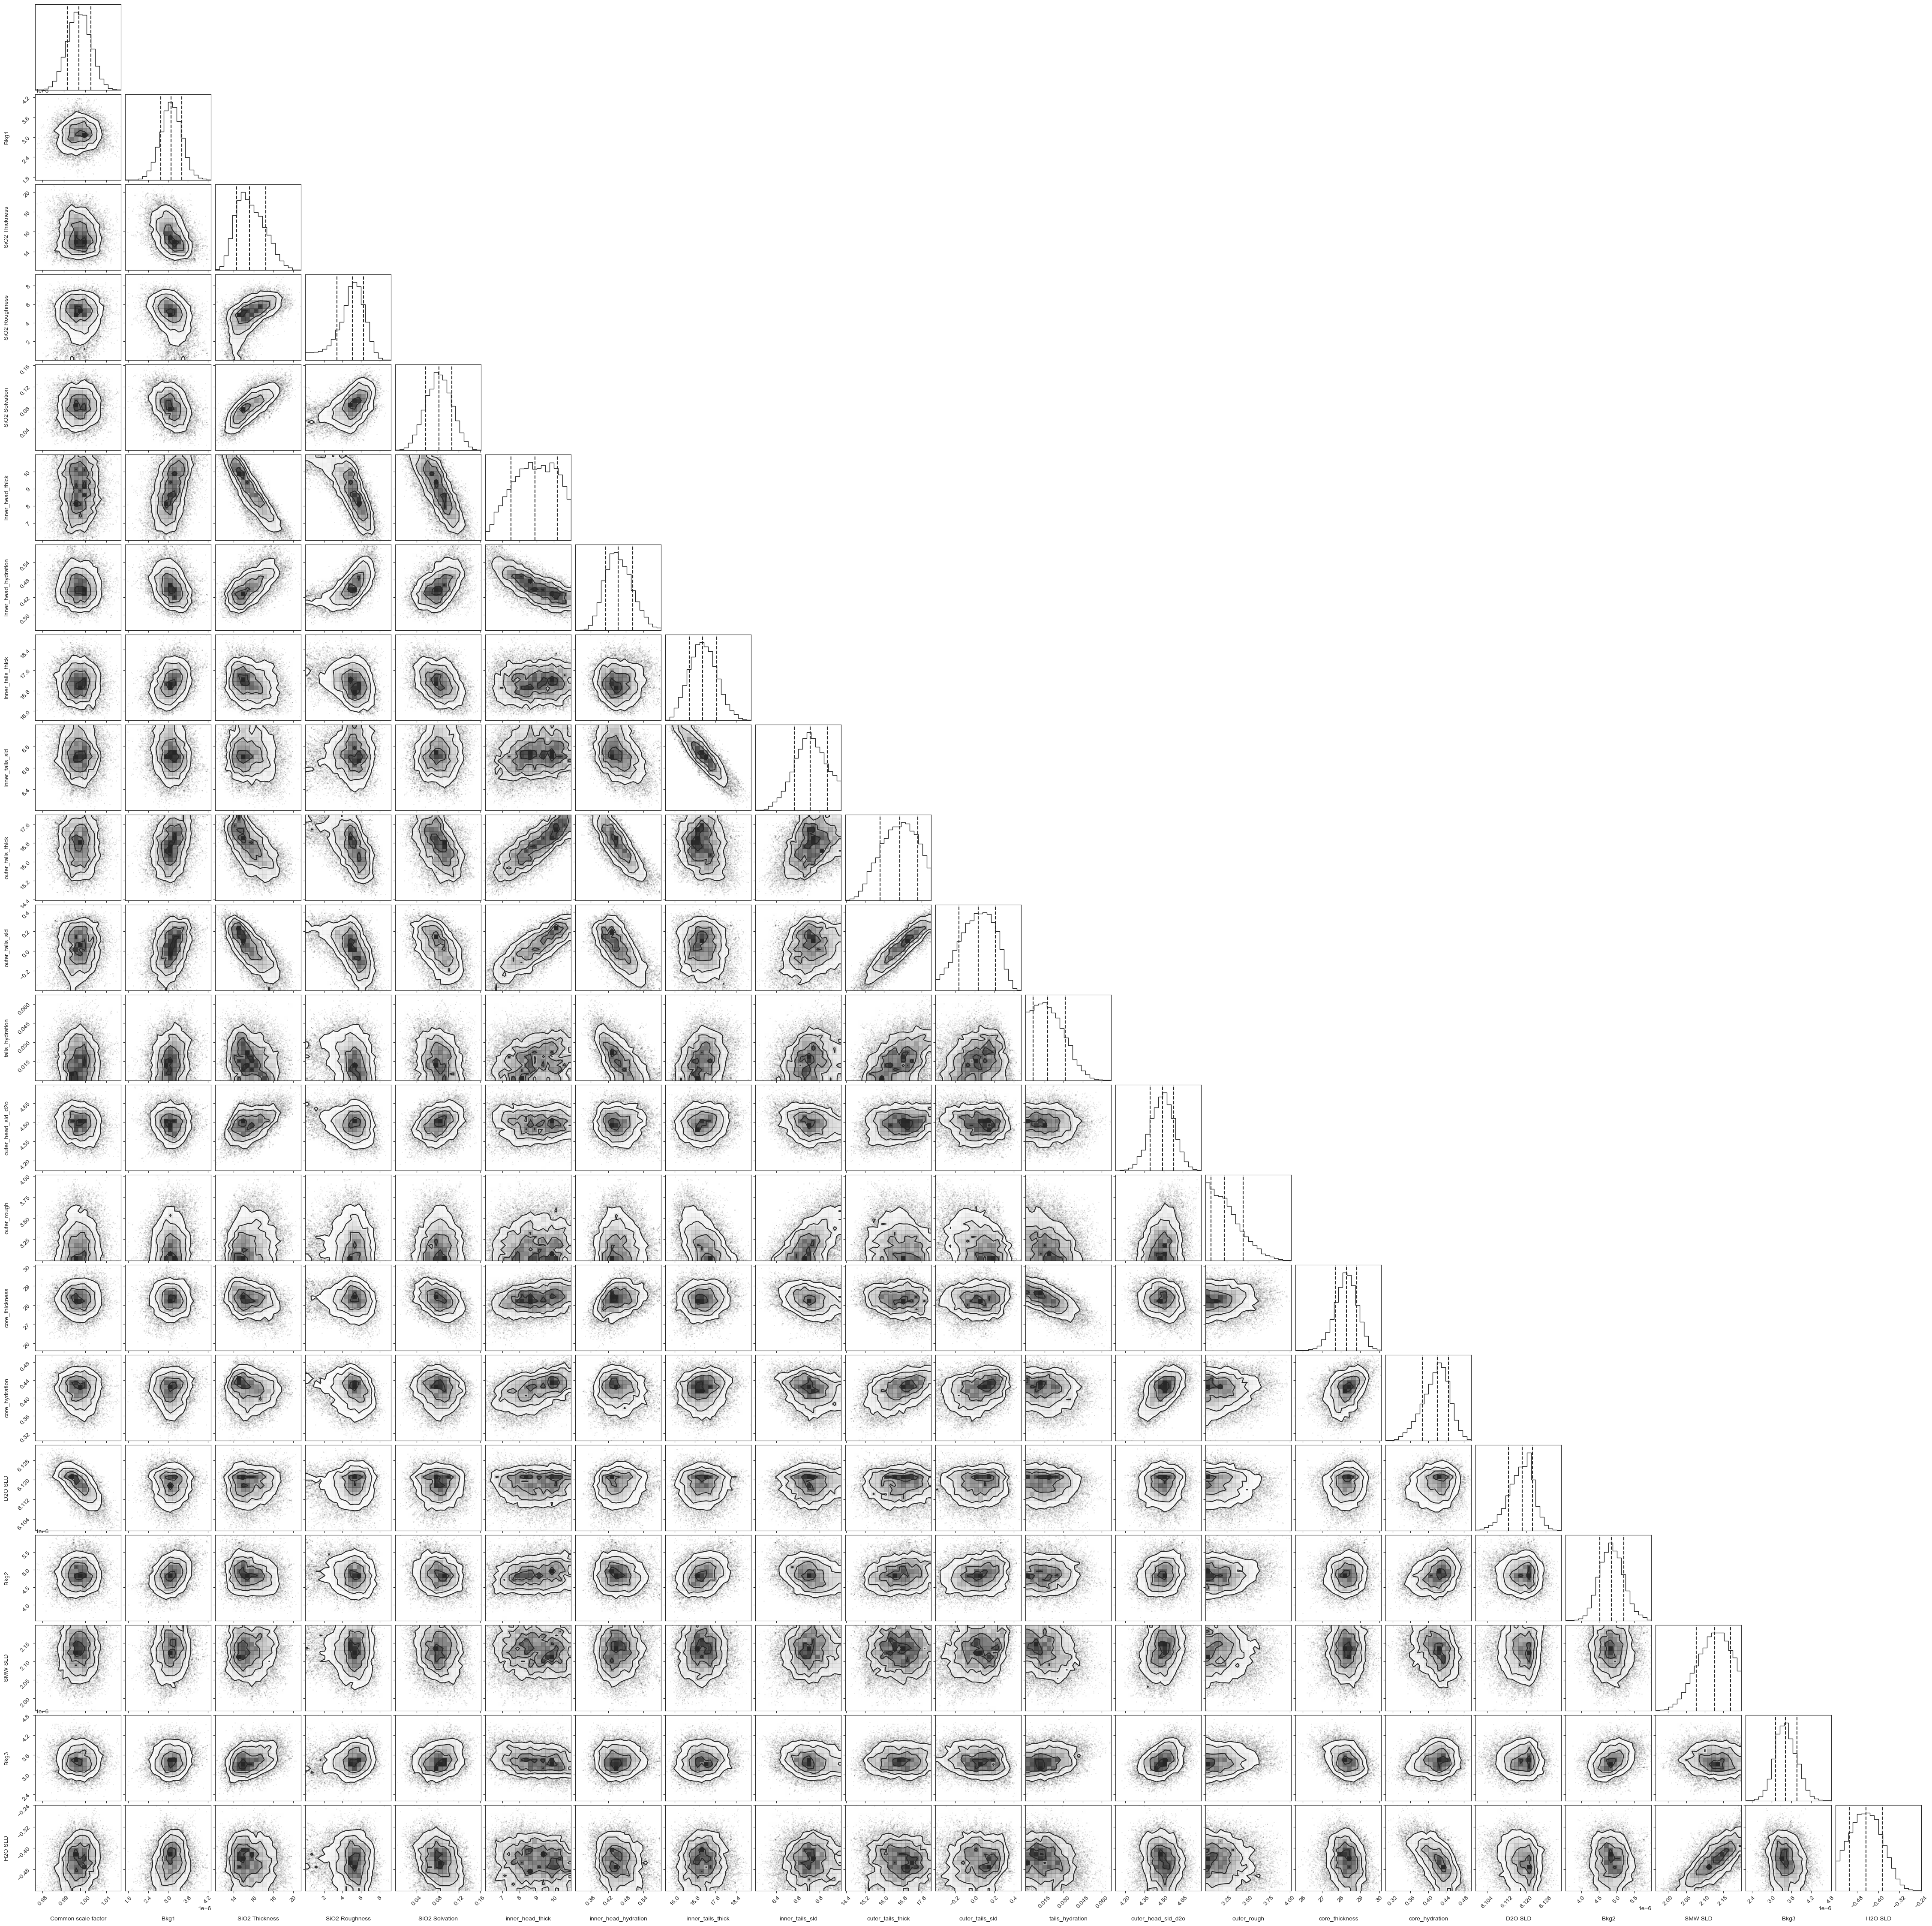

In [19]:
global_objective.corner();
# plt.savefig('Cornerplot')


#### Summary figure

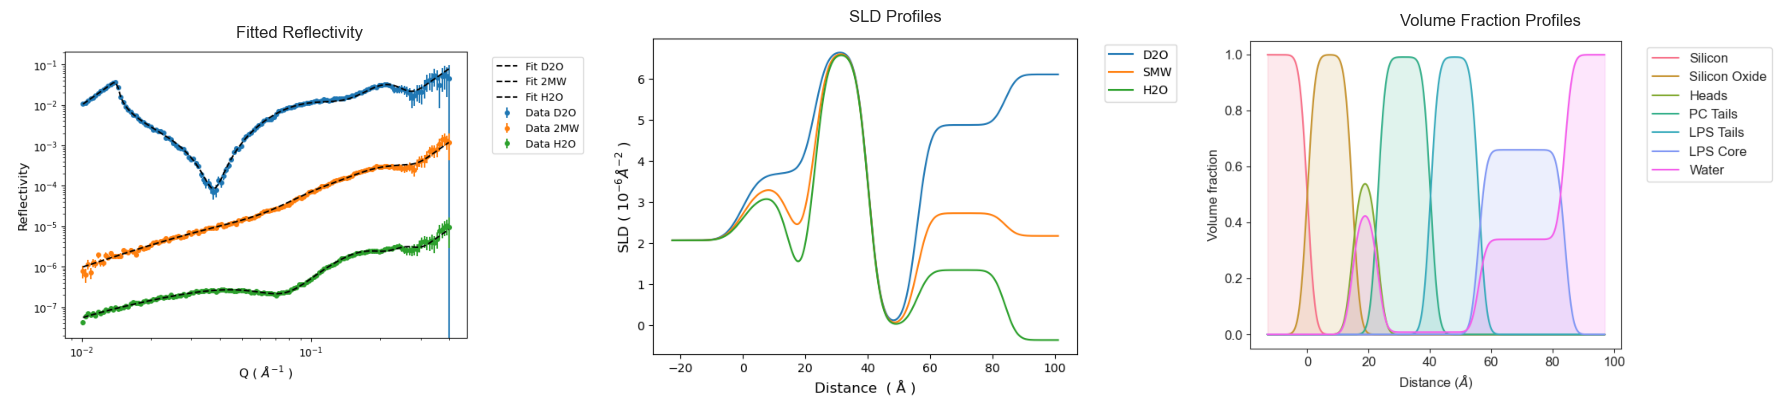

In [20]:
import matplotlib.pyplot as plt

# Create a new figure for assembling the figures
fig_combined = plt.figure(figsize=(18, 6))  # Adjust the figsize as needed

# Create subplots to arrange the individual figures
ax1 = fig_combined.add_subplot(131)  # 1 row, 3 columns, first subplot
ax2 = fig_combined.add_subplot(132)  # 1 row, 3 columns, second subplot
ax3 = fig_combined.add_subplot(133)  # 1 row, 3 columns, third subplot

# Add the individual figures to the subplots
ax1.imshow(fig1.canvas.renderer.buffer_rgba())
ax2.imshow(fig2.canvas.renderer.buffer_rgba())
ax3.imshow(fig3.canvas.renderer.buffer_rgba())

# Optionally, you can add titles or labels to the subplots
ax1.set_title('Fitted Reflectivity')
ax2.set_title('SLD Profiles')
ax3.set_title('Volume Fraction Profiles')

# Remove the axis ticks and labels if desired
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Adjust spacing between subplots
fig_combined.tight_layout()

# Show or save the combined figure
plt.show()


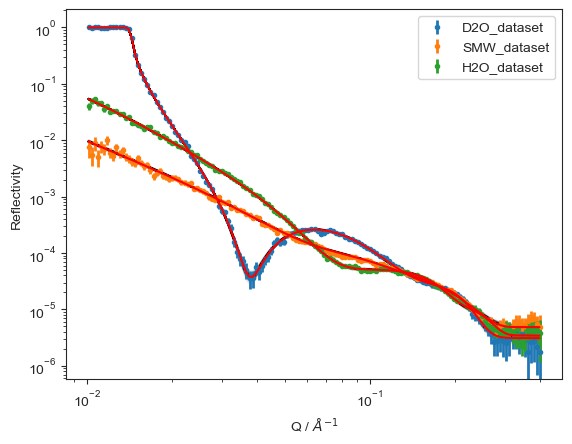

In [21]:
global_objective.plot(samples=300);

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q / $\AA^{-1}$')
plt.ylabel('Reflectivity')
plt.legend();


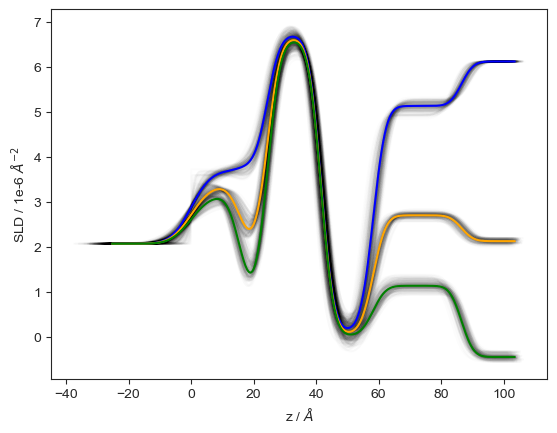

In [22]:
# change the number of samples appropriately.
fig, ax = plt.subplots()
f, a = s_d2o.plot(samples=200, fig=fig)
a.lines[-1].set_color('blue')
f, a = s_smw.plot(samples=200, fig=fig)
a.lines[-1].set_color('orange')
f, a = s_h2o.plot(samples=200, fig=fig);
a.lines[-1].set_color('green');


## Below some diagnostics tools that can be useful to run on the outcome of the MCMC analysis

#### 1. Autocorrelation function (ACF)
#### 2. Running mean
#### 3. R-hat
#### 4. Effective sample size (ESS)
#### 5. Pairwise scatter plots
#### 6. Q-Q plots
#### 7. Ridge plot of posterior densities
#### 8. Violin plot of posterior distributions
#### 9. Residuals plots

### Autocorrelation Diagnostic

#### Description
Autocorrelation function (ACF) for each parameter in the first MCMC chain, showing the correlation between samples at different lags.

#### What to Look For
- **Rapid Decay**: ACF should drop to near zero within a few lags, indicating good mixing and independent samples.
- **Persistent Correlation**: High autocorrelation at large lags suggests poor mixing or strong dependence between samples.


In [ ]:
import matplotlib.pyplot as plt

# Extract parameter names from the actual `global_objective` object
fitted_parameters = global_objective.parameters.varying_parameters()
parameter_names = [param.name for param in fitted_parameters]

# Compare ACFs for multiple parameters
plt.figure(figsize=(10, 6))
for param_idx, param_name in enumerate(parameter_names):  # Loop over parameters
    acf = fitter.acf(0)[:, param_idx]  # Autocorrelation for Chain 0, current parameter
    plt.plot(acf, label=param_name)  # Use parameter name as the label

# Add plot details
plt.title("Autocorrelation Comparison for All Parameters (Chain 1)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend(fontsize='small')  # Adjust legend font size if needed
plt.show()


### Trace Plots for MCMC Chains

#### Description
Trace plots display the sampled values for each parameter across MCMC iterations. Each subplot corresponds to one parameter, and the traces for all MCMC chains are plotted together. The x-axis represents the iteration number, while the y-axis shows the sampled parameter values. 

#### What to Look For
- **Stationarity**: The traces should stabilize (flatten) around a consistent range of values, indicating that the chains have reached the posterior distribution and are sampling effectively.
- **Mixing Across Chains**: The traces for different chains should overlap well, demonstrating good mixing. If traces are widely separated, it may indicate poor convergence or multimodality in the posterior.
- **No Trends or Drift**: A lack of upward or downward trends ensures that the sampler is not stuck exploring specific regions of the parameter space.

These plots are crucial for diagnosing convergence issues and ensuring that the MCMC chains adequately explore the posterior distribution. If poor behavior is observed, increasing the number of burn-in iterations or tuning the sampler's settings may improve the results.


In [ ]:
import matplotlib.pyplot as plt

# Extract parameter names from the actual `global_objective` object
fitted_parameters = global_objective.parameters.varying_parameters()
parameter_names = [param.name for param in fitted_parameters]

# Determine the grid size for subplots
n_params = len(parameter_names)
n_rows = (n_params + 2) // 3  # Adjust rows to fit all parameters
n_cols = 3

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 5 * n_rows), constrained_layout=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot traces for each parameter
for param_idx, param_name in enumerate(parameter_names):
    ax = axes[param_idx]
    for chain_idx in range(fitter.chain.shape[0]):
        ax.plot(fitter.chain[chain_idx, :, param_idx], label=f"Chain {chain_idx + 1}")
    ax.set_title(param_name)  # Use parameter name as the title
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Parameter Value")
    # Uncomment the legend below if space permits
    # ax.legend(loc='best', fontsize='small')

# Hide any unused subplots
for i in range(n_params, len(axes)):
    axes[i].axis('off')

# Show the multi-panel figure
plt.show()


### Residuals Plots for Each Dataset

#### Description
These subplots display the residuals (differences between observed and predicted values) for each dataset included in the global objective. Each subplot corresponds to one dataset, with residuals plotted against the scattering vector (Q). The y-axis limits are shared across all subplots for consistent comparison.

#### What to Look For
- **Random Distribution**: Residuals should scatter randomly around zero without systematic patterns. This indicates that the model captures the data well.
- **No Trends**: Trends or systematic deviations (e.g., curved or linear patterns) suggest model misspecification or unaccounted-for physical effects.
- **Magnitude of Residuals**: Large residuals may indicate regions where the model fits poorly or where the experimental data is less reliable.

These plots help identify specific datasets or Q regions where the fit may need improvement. Adjustments to the model or parameter priors may be necessary if systematic issues are observed.


In [ ]:
import matplotlib.pyplot as plt
import math

# Extract objectives from global_objective
objectives = global_objective.objectives

# Determine the grid layout: 3 columns and as many rows as needed
n_cols = 3
n_rows = math.ceil(len(objectives) / n_cols)  # Calculate number of rows

# Calculate common y-axis limits
all_residuals = []
for objective in objectives:
    all_residuals.extend(objective.residuals())
y_min = min(all_residuals)
y_max = max(all_residuals)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 2), constrained_layout=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through objectives to plot residuals
for i, objective in enumerate(objectives):
    ax = axes[i]
    data = objective.data
    ax.plot(data.x, objective.residuals(), label=data.name)
    ax.set_xlabel('Q')
    ax.set_ylabel('Residuals')
    ax.legend(fontsize='small')  # Smaller legend font size
    ax.set_title(f"Residuals: {data.name}", fontsize='small')  # Add subplot title
    ax.set_ylim(y_min, y_max + 5)  # Apply common y-axis limits

# Hide any unused subplots
for j in range(len(objectives), len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()


### Posterior Distributions for All Parameters

#### Description
These subplots show the posterior distributions for all parameters included in the fit. Each subplot corresponds to a single parameter, with the histogram of MCMC samples overlaid with a kernel density estimate (KDE) for smooth visualization.

#### What to Look For
- **Symmetry**: Distributions should ideally be symmetric and centered, reflecting well-behaved posteriors.
- **Skewness or Multimodality**: Skewed or multimodal distributions may indicate issues such as parameter correlations, poor mixing, or non-convergence.
- **Narrow vs. Wide Distributions**: Narrow distributions suggest high confidence in the parameter estimate, while wider distributions indicate greater uncertainty.

These plots help visualize the uncertainty and shape of the posterior distributions for all fitted parameters, providing insights into parameter identifiability and sampling performance.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Extract parameter names from the actual `global_objective` object
fitted_parameters = global_objective.parameters.varying_parameters()
parameter_names = [param.name for param in fitted_parameters]

# Define the number of columns
n_cols = 4
n_params = len(parameter_names)
n_rows = math.ceil(n_params / n_cols)  # Calculate the number of rows needed

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot histograms for all parameters
for param_idx, param_name in enumerate(parameter_names):
    ax = axes[param_idx]
    samples = fitter.chain[:, :, param_idx].flatten()  # Flatten samples for the current parameter
    sns.histplot(samples, kde=True, bins=30, ax=ax)
    ax.set_title(f"{param_name}", fontsize=10)
    ax.set_xlabel("Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)

# Hide any unused subplots
for idx in range(len(parameter_names), len(axes)):
    axes[idx].axis('off')

# Show the combined figure
plt.show()


### R-hat Diagnostic

#### Description
The R-hat diagnostic assesses the convergence of the MCMC chains for each parameter. Values close to 1 indicate good convergence, where all chains are sampling from the same posterior distribution. This plot displays the R-hat values for all fitted parameters, with a red dashed line marking the threshold of 1.1.

#### What to Look For
- **R-hat ≈ 1.0**: Indicates good convergence. All chains are well-mixed and explore the posterior effectively.
- **R-hat > 1.1**: Suggests convergence issues, such as poor mixing or chains stuck in different regions of the parameter space. Additional MCMC iterations or tuning may be required.

R-hat is a critical diagnostic for ensuring reliable parameter estimates and validating the sampling process.


In [ ]:
import arviz as az  # Ensure you have arviz installed: pip install arviz
import matplotlib.pyplot as plt
import xarray as xr  # Required for conversion

# Convert fitter.chain into an ArviZ InferenceData object
# Assuming fitter.chain is of shape (n_chains, n_samples, n_params)
n_chains, n_samples, n_params = fitter.chain.shape
data = xr.DataArray(
    fitter.chain, 
    dims=["chain", "draw", "param"],
    coords={"param": parameter_names}
)
idata = az.convert_to_inference_data(data)

# Calculate R-hat values
rhat_values = az.rhat(idata)

# Extract R-hat values for plotting
rhat_values_array = rhat_values.to_array().values.flatten()

# Plot R-hat values
plt.figure(figsize=(10, 6))
plt.bar(range(len(rhat_values_array)), rhat_values_array, tick_label=parameter_names)
plt.axhline(1.1, color="red", linestyle="--", label="Threshold (1.1)")
plt.title("R-hat Diagnostic")
plt.ylabel("R-hat")
plt.xlabel("Parameters")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Effective Sample Size (ESS) Diagnostic

#### Description
The Effective Sample Size (ESS) represents the number of effectively independent samples in the MCMC chains after accounting for autocorrelation. This plot displays the ESS for each parameter, with a green dashed line indicating the total posterior samples retained after thinning (total iterations per chain × number of chains / thinning factor).

#### What to Look For
- **High ESS (close to total posterior samples)**: Indicates good mixing and independence between samples, providing reliable parameter estimates.
- **Low ESS**: Suggests strong autocorrelation, which reduces the number of independent samples. This may require increasing the number of iterations or tuning the sampler.

#### Interpretation of This Plot
In this case, the ESS values closely match the total posterior samples, reflecting well-mixed chains with minimal autocorrelation. This indicates high-quality sampling and reliable parameter inference.


In [ ]:
# Calculate ESS for each parameter
ess = az.ess(idata)

# Correct total posterior samples for comparison
total_posterior_samples = fitter.chain.shape[0] * fitter.chain.shape[1]

ess_values_array = ess.to_array().values.flatten()

# Plot ESS with corrected reference line
plt.figure(figsize=(10, 6))
plt.bar(range(len(ess_values_array)), ess_values_array, tick_label=parameter_names)
plt.axhline(total_posterior_samples, color="green", linestyle="--", label=f"Total Posterior Samples ({total_posterior_samples})")
plt.title("Effective Sample Size (ESS) Diagnostic")
plt.ylabel("ESS")
plt.xlabel("Parameters")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Pairwise Scatter Plots of Parameters

#### Description
This plot visualizes the pairwise relationships between all sampled parameters in the posterior. The off-diagonal scatter plots show how pairs of parameters co-vary, while the diagonal plots show the kernel density estimates (KDE) of individual parameters.

#### What to Look For
- **Strong Correlations**: Linear or curved trends in the scatter plots indicate parameter correlations, which may suggest that parameters are not independent in the posterior.
- **Uniform or Random Scatter**: Indicates no significant correlation between parameters, which is desirable for independent posterior samples.
- **Posterior Marginals**: The KDE plots on the diagonal provide insights into the shape and spread of individual parameter distributions.

#### Interpretation of This Plot
These pairwise plots help assess dependencies between parameters and detect potential issues such as high correlations or non-linear relationships, which may suggest model complexity or parameter redundancy.


In [ ]:
import seaborn as sns
import pandas as pd

# Flatten the chain for all parameters into a DataFrame
flat_chain = fitter.chain.reshape(-1, fitter.chain.shape[2])  # Shape: (n_samples * n_chains, n_params)
df = pd.DataFrame(flat_chain, columns=parameter_names)

# Create pairwise scatter plots
sns.pairplot(df, diag_kind="kde", corner=False)
plt.suptitle("Pairwise Scatter Plots of Parameters", y=1.02, fontsize=16)
plt.show()


### Running Mean Diagnostic

#### Description
This plot shows the running mean of each parameter for every chain across iterations. The running mean helps assess the convergence of the MCMC chains. Each subplot corresponds to a parameter, with separate lines representing individual chains.

#### What to Look For
- **Stabilization**: The running mean for each chain should stabilize around the same value after a sufficient number of iterations. This indicates that the chains have converged and are sampling from the posterior distribution.
- **Consistency Across Chains**: Running means for all chains should overlap, demonstrating good mixing and agreement between chains.
- **Trends**: Persistent upward or downward trends in the running mean suggest non-convergence and the need for additional iterations or sampler adjustments.

#### Interpretation of This Plot
Stable and overlapping running means across chains confirm convergence, while instability or divergence signals the need for further diagnostic checks or sampler tuning.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Determine the number of rows and columns for the subplots
n_cols = 4
n_params = len(parameter_names)
n_rows = math.ceil(n_params / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Loop through parameters and plot their running means
for param_idx, param_name in enumerate(parameter_names):
    ax = axes[param_idx]
    for chain_idx in range(fitter.chain.shape[0]):  # Loop over chains
        # Compute running mean for the current chain and parameter
        running_mean = np.cumsum(fitter.chain[chain_idx, :, param_idx]) / np.arange(1, fitter.chain.shape[1] + 1)
        ax.plot(running_mean, label=f"Chain {chain_idx + 1}")
    
    # Add titles and labels
    ax.set_title(param_name, fontsize=10)
    ax.set_xlabel("Iteration", fontsize=8)
    ax.set_ylabel("Running Mean", fontsize=8)
    # ax.legend(fontsize="small", loc="best")

# Hide unused subplots
for idx in range(n_params, len(axes)):
    axes[idx].axis('off')

# Show the figure
plt.show()


### Ridge Plot of Posterior Densities Across Chains

#### Description
This visualization shows the posterior density distributions of each parameter for every MCMC chain. Each subplot corresponds to a parameter, with separate density curves for each chain. The densities provide insights into how well chains mix and whether they are sampling from the same posterior distribution.

#### What to Look For
- **Overlap Between Chains**: The density curves for different chains should overlap closely, indicating that all chains converge to the same posterior distribution. Lack of overlap suggests convergence issues or multimodality in the posterior.
- **Shape of Densities**: Each density plot reveals the shape of the posterior for a parameter:
  - Symmetric densities indicate well-behaved, unimodal posteriors.
  - Skewed or irregular densities might suggest poor sampling or parameter constraints.
  - Multimodal densities indicate that the chains are sampling from different regions of the parameter space.
- **Consistency Across Chains**: Check for any chain-specific deviations or irregularities.

#### Interpretation of This Plot
- Well-overlapping density curves across chains confirm good mixing and convergence of the MCMC sampler.
- Parameters with skewed or multimodal densities may require further investigation into sampling performance, priors, or the model's structure.

This plot is an important diagnostic to ensure the reliability of the posterior samples and to identify any parameters or chains that require further attention.


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

# Flatten the chain and organize the samples into a DataFrame
samples_per_chain = fitter.chain.reshape(fitter.chain.shape[0], -1, fitter.chain.shape[2])  # (n_chains, n_samples, n_params)
ridge_data = []

# Prepare data for ridge plot
for chain_idx, chain_samples in enumerate(samples_per_chain):  # Loop through chains
    for param_idx, param_name in enumerate(parameter_names):  # Loop through parameters
        ridge_data.append(pd.DataFrame({
            "Parameter": param_name,
            "Value": chain_samples[:, param_idx],
            "Chain": f"Chain {chain_idx + 1}"
        }))

# Combine data for all chains
ridge_data = pd.concat(ridge_data, ignore_index=True)

# Number of parameters
n_params = len(parameter_names)
n_cols = 3
n_rows = math.ceil(n_params / n_cols)  # Calculate number of rows needed

# Create subplots with 3 columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through parameters and plot ridge densities for each parameter
for idx, param_name in enumerate(parameter_names):
    ax = axes[idx]
    sns.kdeplot(
        data=ridge_data[ridge_data["Parameter"] == param_name],
        x="Value", hue="Chain", fill=True, alpha=0.6, ax=ax, palette="tab10", legend=False
    )
    ax.set_title(param_name, fontsize=12)
    ax.set_xlabel("Parameter Value", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)

# Hide any unused subplots
for idx in range(len(parameter_names), len(axes)):
    axes[idx].axis("off")

plt.show()


### Autocorrelation Diagnostic for All Parameters

#### Description
This plot visualizes the autocorrelation of posterior samples for each parameter as a function of lag. Each subplot corresponds to a single parameter, with the x-axis showing the lag (distance between samples) and the y-axis showing the autocorrelation. The autocorrelation quantifies the dependence of a parameter's samples on previous samples.

#### What to Look For
- **Rapid Decay to Zero**: Autocorrelation should drop to near zero within a few lags, indicating that the samples are approximately independent and the MCMC chains are mixing well.
- **Persistent Autocorrelation**: If autocorrelation remains high at large lags, it indicates strong dependence between samples, which reduces the effective sample size and may require increased thinning or longer chains.
- **Zero Baseline**: The dashed horizontal line at zero serves as a reference. Points fluctuating randomly around zero after a few lags suggest effective sampling.

#### Interpretation of This Plot
Rapidly decaying autocorrelation across all parameters confirms good chain mixing and independence between samples, ensuring reliable posterior estimates. Parameters with slow-decaying autocorrelation may need additional iterations, tuning of the sampler, or adjustments to the model to improve sampling efficiency.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate autocorrelation for a given lag
def autocorrelation(chain, lag):
    n = len(chain)
    return np.corrcoef(chain[:-lag], chain[lag:])[0, 1] if lag < n else np.nan

# Parameters for the plot
max_lag = 100  # Maximum number of lags to calculate
n_cols = 3
n_params = len(parameter_names)
n_rows = math.ceil(n_params / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through each parameter to calculate and plot autocorrelation
for param_idx, param_name in enumerate(parameter_names):
    ax = axes[param_idx]
    chain_data = fitter.chain[:, :, param_idx].reshape(-1)  # Combine chains into one flat chain
    lags = np.arange(1, max_lag + 1)
    autocorrs = [autocorrelation(chain_data, lag) for lag in lags]
    
    # Plot the autocorrelation
    ax.plot(lags, autocorrs, marker="o", linestyle="-")
    ax.set_title(param_name, fontsize=12)
    ax.set_xlabel("Lag", fontsize=10)
    ax.set_ylabel("Autocorrelation", fontsize=10)
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")  # Zero baseline for reference

# Hide unused subplots
for idx in range(len(parameter_names), len(axes)):
    axes[idx].axis("off")

plt.show()


### Violin Plot of Posterior Distributions

#### Description
These violin plots visualize the posterior distributions of each parameter, showing the density and spread of the MCMC samples. Each subplot corresponds to a single parameter, with the x-axis representing the parameter values and the y-axis showing the density.

#### What to Look For
- **Shape of the Distribution**: 
  - Symmetric violin shapes indicate well-behaved, unimodal posteriors.
  - Skewed or irregular shapes suggest potential issues such as parameter constraints, poor sampling, or strong prior influence.
- **Spread of the Distribution**: 
  - Wider violins indicate greater uncertainty in the parameter estimate, while narrower violins suggest higher confidence.
- **Quartiles**: Inner lines within the violins represent the interquartile range (25th, 50th, and 75th percentiles), which helps assess the central tendency and spread.

#### Interpretation of This Plot
Well-behaved posterior distributions should have smooth, symmetric shapes and reasonable spread, reflecting good sampling and reliable parameter inference. Skewness, multimodality, or irregularities may warrant further investigation into the model, priors, or sampling process.


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

# Flatten the chain and organize the samples into a DataFrame
flat_chain = fitter.chain.reshape(-1, fitter.chain.shape[2])  # Flatten chains across iterations
posterior_data = pd.DataFrame(flat_chain, columns=parameter_names)  # Use parameter names as columns

# Number of rows and columns for subplots
n_cols = 3
n_params = len(parameter_names)
n_rows = math.ceil(n_params / n_cols)

# Create subplots with independent x-axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through parameters and create a violin plot for each
for idx, param_name in enumerate(parameter_names):
    ax = axes[idx]
    sns.violinplot(
        data=posterior_data, 
        x=param_name, 
        ax=ax, 
        scale="width", 
        inner="quartile", 
        bw=0.2
    )
    ax.set_title(param_name, fontsize=12)
    ax.set_xlabel("Parameter Value", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)

# Hide unused subplots
for idx in range(len(parameter_names), len(axes)):
    axes[idx].axis("off")

plt.show()


### Q-Q Plots for Posterior Samples

#### Description
Quantile-Quantile (Q-Q) plots compare the quantiles of the posterior samples for each parameter (empirical quantiles) against the quantiles of a theoretical normal distribution. Each subplot corresponds to a single parameter, allowing for the evaluation of how closely the posterior distribution aligns with a normal distribution.

#### What to Look For
- **Points Aligning with the Red Line**:
  - If the posterior samples follow a normal distribution, the points will closely align with the red dashed line. This indicates that the parameter's posterior is approximately normal.
- **Deviations from the Red Line**:
  - Systematic deviations (e.g., curvature, clustering) suggest that the posterior distribution is non-normal. For instance:
    - **S-shaped Curvature**: Indicates skewness in the posterior.
    - **Heavy Tails**: Points deviating at the extremes (high or low quantiles) suggest heavier or lighter tails compared to a normal distribution.
    - **Nonlinear Patterns**: May indicate multimodality or other irregularities in the posterior.

#### Interpretation of This Plot
- **Good Alignment**: Parameters with points closely following the red line have posteriors that approximate normal distributions. This is typically desirable and suggests well-behaved sampling.
- **Non-Normal Posteriors**: Parameters showing significant deviations from normality may require further investigation. This could result from skewness, strong priors, or model misspecification.

Q-Q plots are particularly useful for diagnosing issues in parameter distributions and ensuring the assumptions of normality (if applicable) are met.


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

# Number of rows and columns for subplots
n_cols = 3
n_params = len(parameter_names)
n_rows = math.ceil(n_params / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through parameters and create Q-Q plots
for param_idx, param_name in enumerate(parameter_names):
    ax = axes[param_idx]
    # Combine chains into one flat array for the parameter
    samples = fitter.chain[:, :, param_idx].flatten()
    # Generate Q-Q plot data
    (osm, osr), (slope, intercept, r) = stats.probplot(samples, dist="norm")
    # Plot Q-Q
    ax.scatter(osm, osr, alpha=0.6)
    ax.plot(osm, slope * osm + intercept, color="red", linestyle="--")  # Best-fit line
    ax.set_title(param_name, fontsize=12)
    ax.set_xlabel("Theoretical Quantiles", fontsize=10)
    ax.set_ylabel("Sample Quantiles", fontsize=10)

# Hide unused subplots
for idx in range(len(parameter_names), len(axes)):
    axes[idx].axis("off")

plt.show()
